### Import libraries

In [1]:
import torchvision.transforms as T
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import pyplot
import numpy as np
import os
import torch
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import cv2
import random
import math
import copy

import sklearn.metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [2]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Check if model exists

In [3]:
# save_checkpoint = True
# start_from_checkpoint = False
# save_dir = 'Models'
# model_name = 'Res_18_Pipes'

# #Create Save Path from save_dir and model_name, we will save and load our checkpoint here
# save_path = os.path.join(save_dir, model_name + ".pt")

# #Create the save directory if it does note exist
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)

# #Load Checkpoint
# if start_from_checkpoint:
#     #Check if checkpoint exists
#     if os.path.isfile(save_path):
#         #load Checkpoint
#         check_point = torch.load(save_path)
#         #Checkpoint is saved as a python dictionary
#         #https://www.w3schools.com/python/python_dictionaries.asp
#         #here we unpack the dictionary to get our previous training states
#         model.load_state_dict(check_point['model_state_dict'])
#         optimizer.load_state_dict(check_point['optimizer_state_dict'])
#         start_epoch = check_point['epoch']
#         best_valid_acc = check_point['valid_acc']
#         print("Checkpoint loaded, starting from epoch:", start_epoch)
#     else:
#         #Raise Error if it does not exist
#         raise ValueError("Checkpoint Does not exist")
# else:
#     #If checkpoint does exist and Start_From_Checkpoint = False
#     #Raise an error to prevent accidental overwriting
#     if os.path.isfile(save_path):
#         #raise ValueError("Warning Checkpoint model already exists, please delete to overwrite")
#         print('model already exists')
#         os.remove(save_path)
#     else:
#         print("Starting from scratch")

In [4]:
class CustomDataSet(Dataset):
    def __init__(self,model, trn_val_tst = 0, transform=None):
        if model == 'external':
            data = np.load('Models/external.npz')
        elif model == 'internal':
            data = np.load('Models/internal.npz')
        if trn_val_tst == 0:
            #trainloader
            self.images = data['train_imgs']
            self.labels = data['train_labels']
        elif trn_val_tst == 1:
            #valloader
            self.images = data['valid_imgs']
            self.labels = data['valid_labels']
        else:
            #testloader
            self.images = data['test_imgs']
            self.labels = data['test_labels']


        self.images = np.float32(self.images)/1.0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, labels

### Data Augmentation

In [5]:
# image augmentation
transforms = T.Compose([
    T.ToTensor(),
        T.RandomApply(torch.nn.ModuleList([
            T.ColorJitter(brightness=0,contrast=0.5,saturation=0.5,hue=0.4),
            T.RandomHorizontalFlip(p=0.5), #random Horizontal flip with 50% chance
            T.RandomRotation(90, fill=0),
            T.RandomVerticalFlip(p=0.5),
            T.RandomAffine(degrees = (0,0), translate = (0.3,0.3)), 
        ]), p=0.65)
    ])

### Model training and validation

In [6]:
def train(model, device, loader, optimizer, loss_fun, loss_logger):
    
    #Set Network in train mode
    model.train()
    
    count = 0
    total_loss = 0
    
    for i, (x, y) in enumerate(loader):
        #Perform a single epoch of training on the input dataloader, logging the loss at every step 
        #Forward pass of image through network and get output
        fx = model(x.to(device))
        y = y.type(torch.LongTensor)

        #Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))
        total_loss += loss.item()
        count += 1
        
        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()

    #log the loss PER EPOCH for plotting
    loss_logger.append(total_loss/count)
   
    #return the logger array       
    return loss_logger

In [7]:
def evaluate(model, device, loader, loss_fun):
    
    #initialise counter
    epoch_acc = 0
    count = 0
    total_loss = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation
    #and use current stored values
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            #Forward pass of image through network
            fx = model(x.to(device))
            y = y.type(torch.LongTensor)
            
            #log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()
            
            #calculate the loss
            loss = loss_fun(fx, y.to(device))
            total_loss += loss.item()
            count += 1
    
    # Calculating the average loss per epoch
    loss_per_epoch = total_loss/count
    #return the accuracy from the epoch     
    return epoch_acc*100 / len(loader.dataset), loss_per_epoch

### External Model

In [8]:
train_set1 = CustomDataSet(model = 'external', trn_val_tst=0, transform=transforms)
# valid_set = CustomDataSet(model = 'external',trn_val_tst=1, transform=torchvision.transforms.ToTensor())
test_set1 = CustomDataSet(model = 'external', trn_val_tst=2, transform=torchvision.transforms.ToTensor())

batch_size = 10
trainloader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)
# validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
testloader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=True)

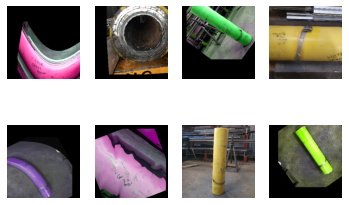

In [9]:
# check augmentation 
image_batch, labels = next(iter(trainloader1))
for tmpC1 in range(8):    
    img = np.moveaxis(image_batch[tmpC1].numpy(),0,2)
    plt.subplot(2,4,tmpC1+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

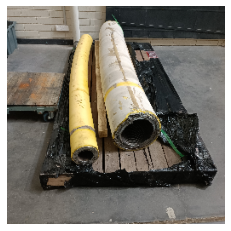

0


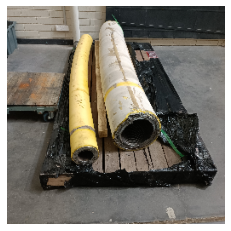

0


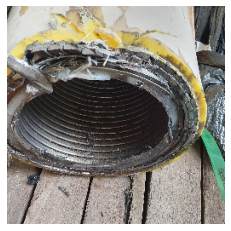

0


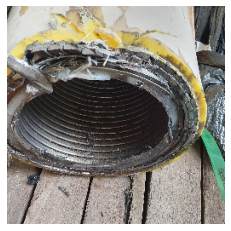

0


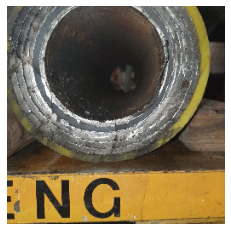

0


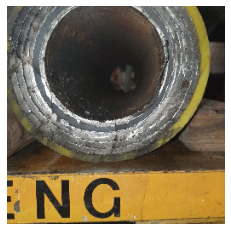

0


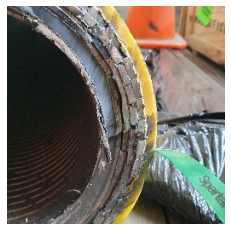

0


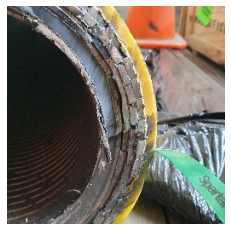

0


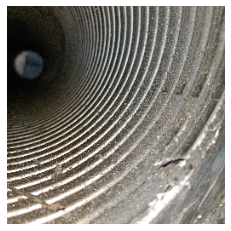

0


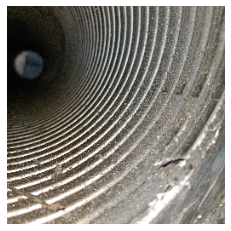

0


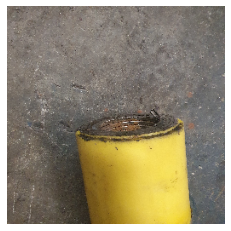

0


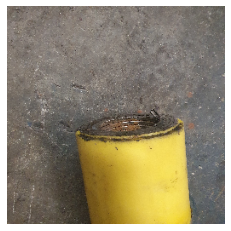

0


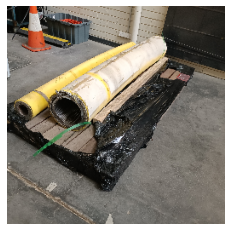

0


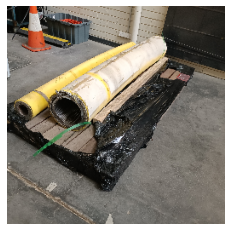

0


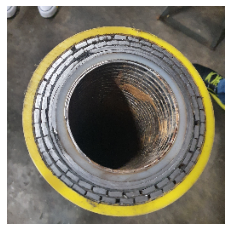

0


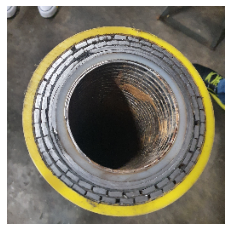

0


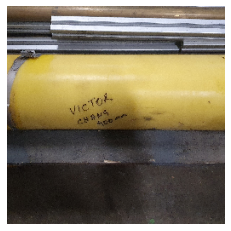

0


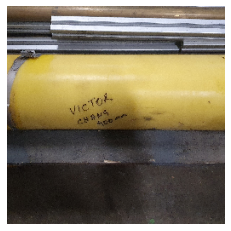

0


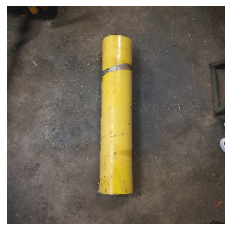

0


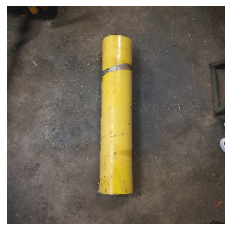

0


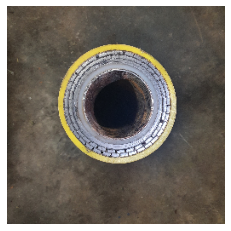

0


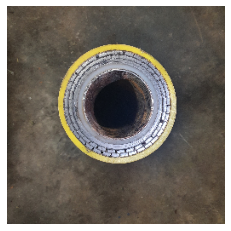

0


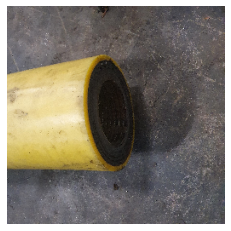

0


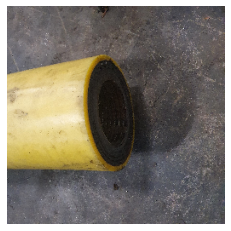

0


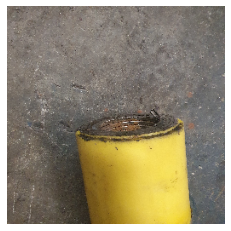

0


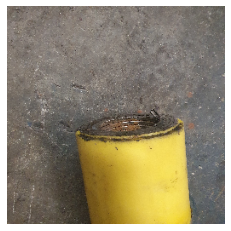

0


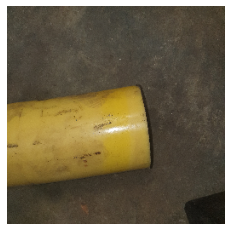

0


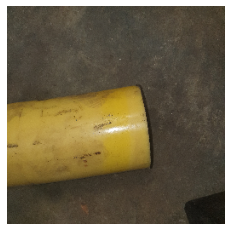

0


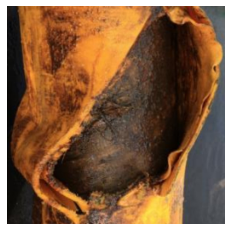

1


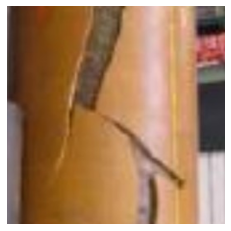

1


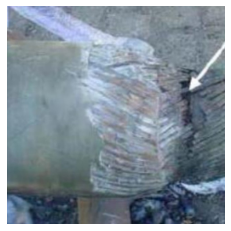

1


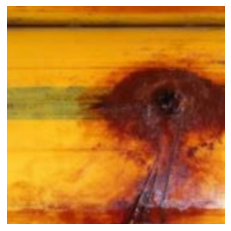

1


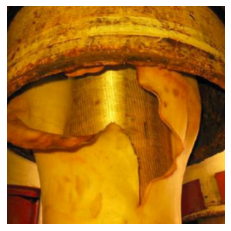

1


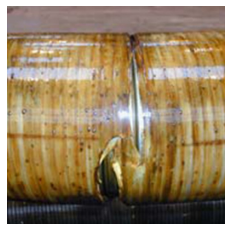

1


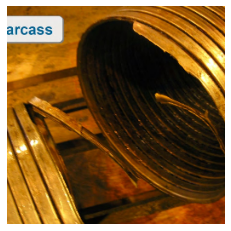

1


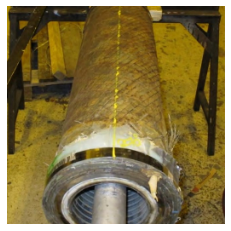

1


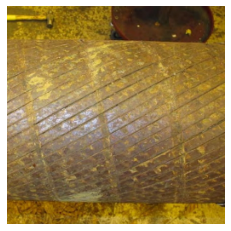

1


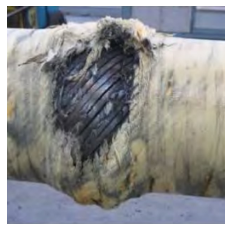

1


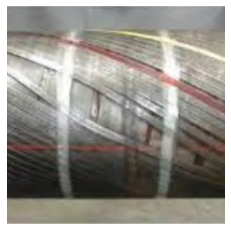

1


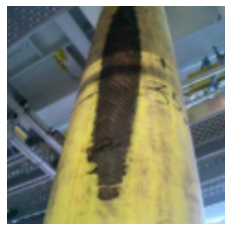

1


In [10]:
# Check if images are correct from .npz file
data = np.load('Models/external.npz')
x_images = data['test_imgs']
x_labels = data['test_labels']

for i in range(len(x_images)):
    img = x_images[i]
    pyplot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pyplot.axis("off")
    pyplot.show()
    print(x_labels[i])

In [12]:
import importlib
m = importlib.import_module("training")
importlib.reload(m)
from training import training 
learning_rate =7e-6
num_epochs = 50  

training_loss_logger1, training_acc_logger1, testing_acc_logger1, testing_loss_logger1, highest_test_acc1,model = training(device,trainloader1,testloader1,evaluate,train,learning_rate,num_epochs)

| Epoch: 50 | Train Acc: 99.04% | Val. Acc: 00.00% | Test Acc: 80.00%
Training Complete
The final test accuracy is  80.0
The highest test accuracy is  80.0


### Internal Model

In [13]:
train_set2 = CustomDataSet(model = 'internal', trn_val_tst=0, transform=transforms)
# valid_set = CustomDataSet(model = 'internal',trn_val_tst=1, transform=torchvision.transforms.ToTensor())
test_set2 = CustomDataSet(model = 'internal', trn_val_tst=2, transform=torchvision.transforms.ToTensor())

batch_size = 15
trainloader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)
# validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
testloader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=True)

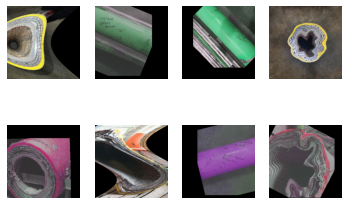

In [14]:
image_batch, labels = next(iter(trainloader2))
for tmpC1 in range(8):    
    img = np.moveaxis(image_batch[tmpC1].numpy(),0,2)
    plt.subplot(2,4,tmpC1+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

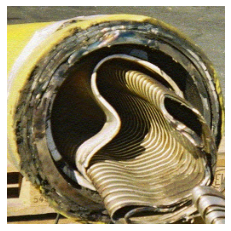

1


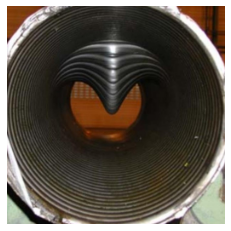

1


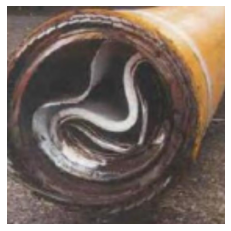

1


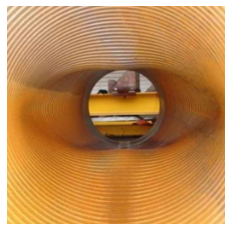

1


In [15]:
# Check if images are correct from .npz file
data = np.load('Models/internal.npz')
x_images = data['test_imgs']
x_labels = data['test_labels']

for i in range(len(x_images)):
    img = x_images[i]
    pyplot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pyplot.axis("off")
    pyplot.show()
    print(x_labels[i])

In [18]:
learning_rate =7e-6
num_epochs = 30
training_loss_logger2, training_acc_logger2, testing_acc_logger2, testing_loss_logger2, highest_test_acc2,model= training(device,trainloader2,testloader2,evaluate,train,learning_rate,num_epochs)

| Epoch: 30 | Train Acc: 100.00% | Val. Acc: 00.00% | Test Acc: 75.00%
Training Complete
The final test accuracy is  75.0
The highest test accuracy is  75.0


### Plot loss and accuracy

External Model and Internal Model


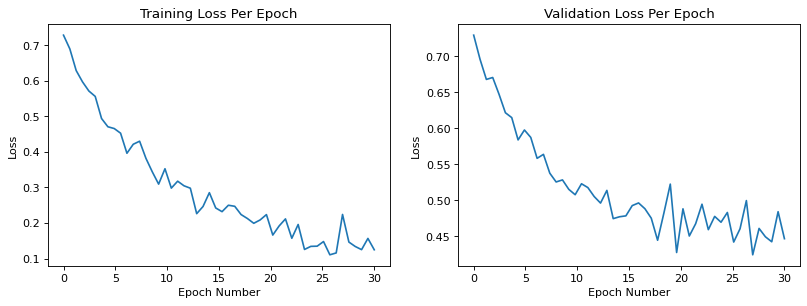

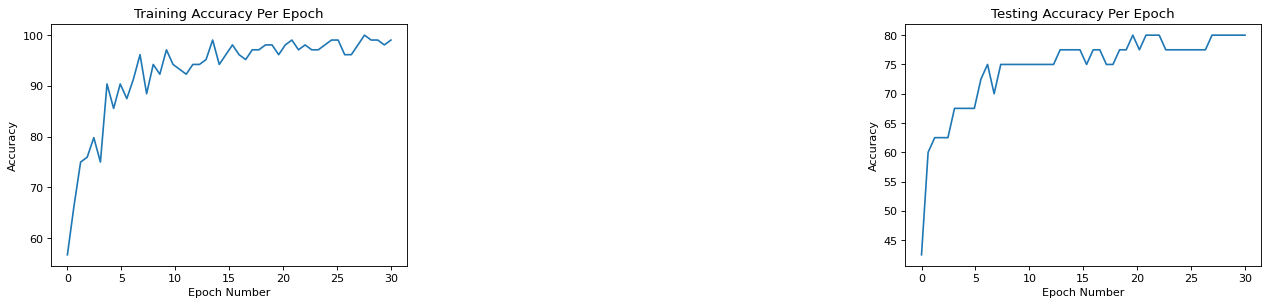

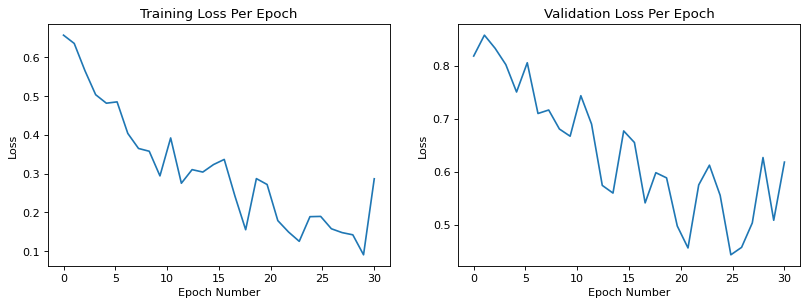

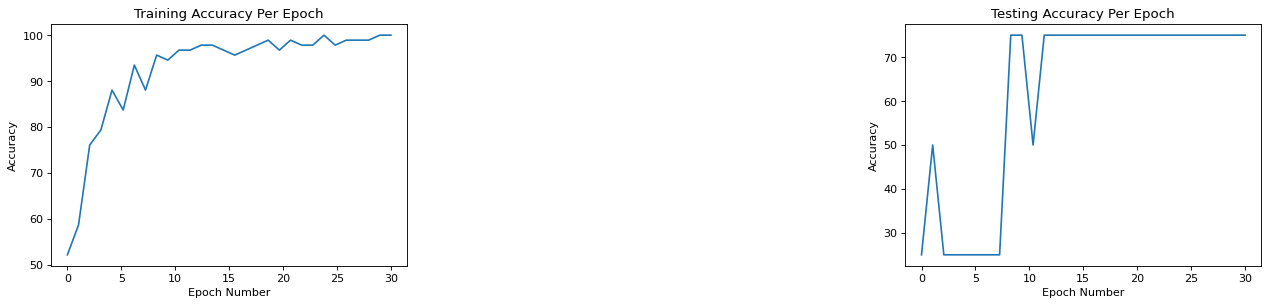

In [19]:
from visualisation import plotting
print('External Model and Internal Model')
plotting(num_epochs,training_loss_logger1,training_acc_logger1,testing_acc_logger1,testing_loss_logger1)
plotting(num_epochs,training_loss_logger2,training_acc_logger2,testing_acc_logger2,testing_loss_logger2)

### Manually test data

#### External Model

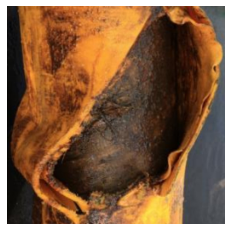

Predicted label:  Not damaged
True label:  Externally Damaged


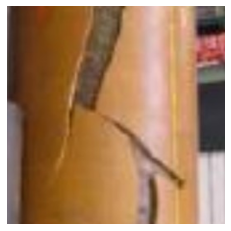

Predicted label:  Not damaged
True label:  Externally Damaged


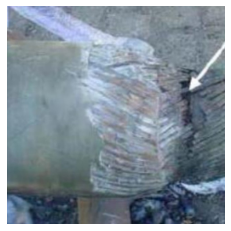

Predicted label:  Not damaged
True label:  Externally Damaged


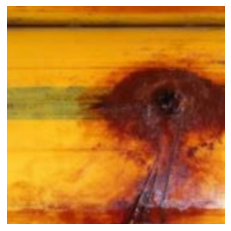

Predicted label:  Not damaged
True label:  Externally Damaged


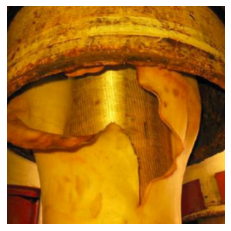

Predicted label:  Not damaged
True label:  Externally Damaged


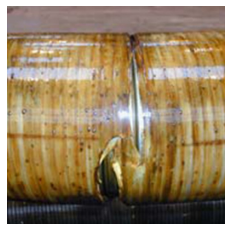

Predicted label:  Not damaged
True label:  Externally Damaged


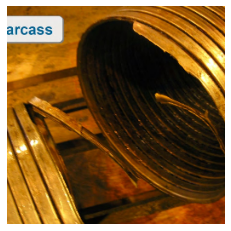

Predicted label:  Not damaged
True label:  Externally Damaged


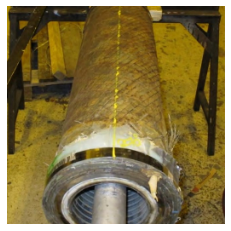

Predicted label:  Not damaged
True label:  Externally Damaged


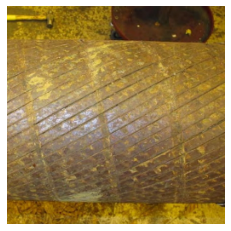

Predicted label:  Not damaged
True label:  Externally Damaged


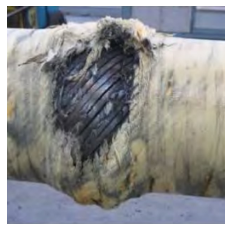

Predicted label:  Not damaged
True label:  Externally Damaged


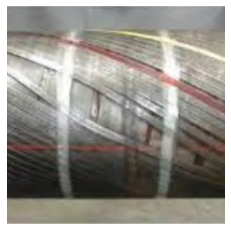

Predicted label:  Not damaged
True label:  Externally Damaged


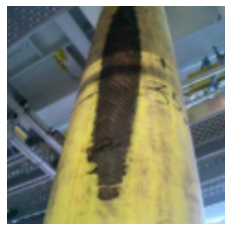

Predicted label:  Not damaged
True label:  Externally Damaged
                 Predicted Positive  Predicted Negative  Sum
Actual Positive                   0                  12   12
Actual Negative                   0                  28   28
Sum                               0                  40   40


In [24]:
label_map = {
    "0": "Not damaged",
    "1": "Externally Damaged"
}

from visualisation import confusion_matrix

#check_point = torch.load(save_path)
#model.load_state_dict(check_point['model_state_dict'])
#test_acc, _ = evaluate(model, device, testloader1, loss_fun)
#print('Test accuracy is: ',test_acc)

data = np.load('Models/external.npz')
test_images = data['test_imgs']
test_labels = data['test_labels']

pred_labels1 = []
for i in range(len(test_images)):
    img = test_images[i]
    output = model(torch.unsqueeze(torch.moveaxis(torch.from_numpy(img), 2,0), dim=0).to(device))
    predicted_label = np.argmax(output.cpu().detach().numpy(), 1)[0]
    pred_labels1.append(predicted_label)
    true_label = test_labels[i]
    
    if true_label != predicted_label:
        pyplot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pyplot.axis("off")
        pyplot.show()
        print('Predicted label: ', label_map[str(predicted_label)])
        print('True label: ', label_map[str(true_label)])

cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels1)
#print(cm)

# expand confusion matrix and print the confusion table
df_cm = confusion_matrix(cm)
print(df_cm)


#### Internal Model

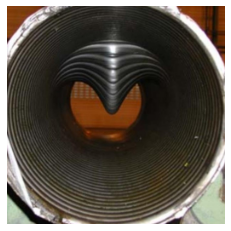

Predicted label:  Not damaged
True label:  Internally Damaged
                 Predicted Positive  Predicted Negative  Sum
Actual Positive                   3                   1    4
Actual Negative                   0                   0    0
Sum                               3                   1    4


In [25]:
label_map = {
    "0": "Not damaged",
    "1": "Internally Damaged"
}
from visualisation import confusion_matrix

#check_point = torch.load(save_path)
#model.load_state_dict(check_point['model_state_dict'])
#test_acc, _ = evaluate(model, device, testloader1, loss_fun)
#print('Test accuracy is: ',test_acc)

data = np.load('Models/internal.npz')
test_images = data['test_imgs']
test_labels = data['test_labels']

pred_labels2 = []
for i in range(len(test_images)):
    img = test_images[i]
    output = model(torch.unsqueeze(torch.moveaxis(torch.from_numpy(img), 2,0), dim=0).to(device))
    predicted_label = np.argmax(output.cpu().detach().numpy(), 1)[0]
    pred_labels2.append(predicted_label)
    true_label = test_labels[i]
    
    if true_label != predicted_label:
        pyplot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        pyplot.axis("off")
        pyplot.show()
        print('Predicted label: ', label_map[str(predicted_label)])
        print('True label: ', label_map[str(true_label)])

cm = sklearn.metrics.confusion_matrix(test_labels, pred_labels2)
#print(cm)

# expand confusion matrix and print the confusion table
df_cm = confusion_matrix(cm)
print(df_cm)


### Combine labels

In [1]:
# need to make sure the test pipe image matches for each model.
if not len(pred_labels1)==len(pred_labels2):
    print('The test dataset is incorrect')

final_labels = pred_labels1
print(final_labels)

for index in range(len(pred_labels2)):
    # internal damage
    if pred_labels1[index] == 0 and pred_labels2[index] == 1:
        final_labels[index] = 2
    # external damage
    if pred_labels1[index] == 1 and pred_labels2[index] == 0:
        final_labels[index] = 1
    # internal and external damage
    if pred_labels1[index] == 1 and pred_labels2[index] == 1:
        final_labels[index] = 3
        
print(final_labels)


NameError: name 'pred_labels1' is not defined